In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

In [28]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

In [3]:
df1=pd.read_csv('traffic_training.csv')

In [4]:
df1.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

In [5]:
df_n=df1.groupby(['geohash6','day']).count()
df_n=df_n[['timestamp']]
df_n.head()

timestamp
geohash6 day           
qp02yc   1            7
         2            5
         3            7
         4           13
         5            4

In [6]:
df_d=df1.groupby(['geohash6','day']).sum()
df_d=df_d[['demand']]
df_d.head()

demand
geohash6 day          
qp02yc   1    0.069709
         2    0.116512
         3    0.125697
         4    0.291252
         5    0.071204

In [7]:
df_all=pd.merge(df_n,df_d, left_index=True, right_index=True)

In [8]:
df_an=df_all.reset_index(level=['geohash6', 'day'])

In [11]:
df_an.groupby(['geohash6']).sum().sort_values('demand').sample(n=10)

,day,timestamp,demand
geohash6,,,
qp0d5c,1720,511,5.508307
qp03y8,1891,5831,683.573426
qp03xr,1891,5787,830.699275
qp03pb,1891,3980,527.659798
qp06nt,1891,608,3.052137
qp098e,1891,5753,426.053121
qp091d,1681,160,1.165290
qp09f6,1891,4015,140.804509
qp09h5,1891,3294,79.075879


In [22]:
df_t=df_an.loc[df_an['geohash6']=='qp098e']
df_t=df_t[['day','demand']]
df_t=df_t.set_index('day')
df_t = df_t['demand']

df_t.head()

day
1    3.811251
2    7.399387
3    7.316148
4    8.925688
5    4.820643
Name: demand, dtype: float64

In [23]:
index=range(1,62)
index

columns=['demands']
df_null = pd.DataFrame(index=index, columns=columns)
df_null.head()

,demands
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN


In [30]:
df_for=df_null.join(df_t)
df_for=df_for[['demand']].fillna(0)
df_for.head()

,demand
1,3.811251
2,7.399387
3,7.316148
4,8.925688
5,4.820643


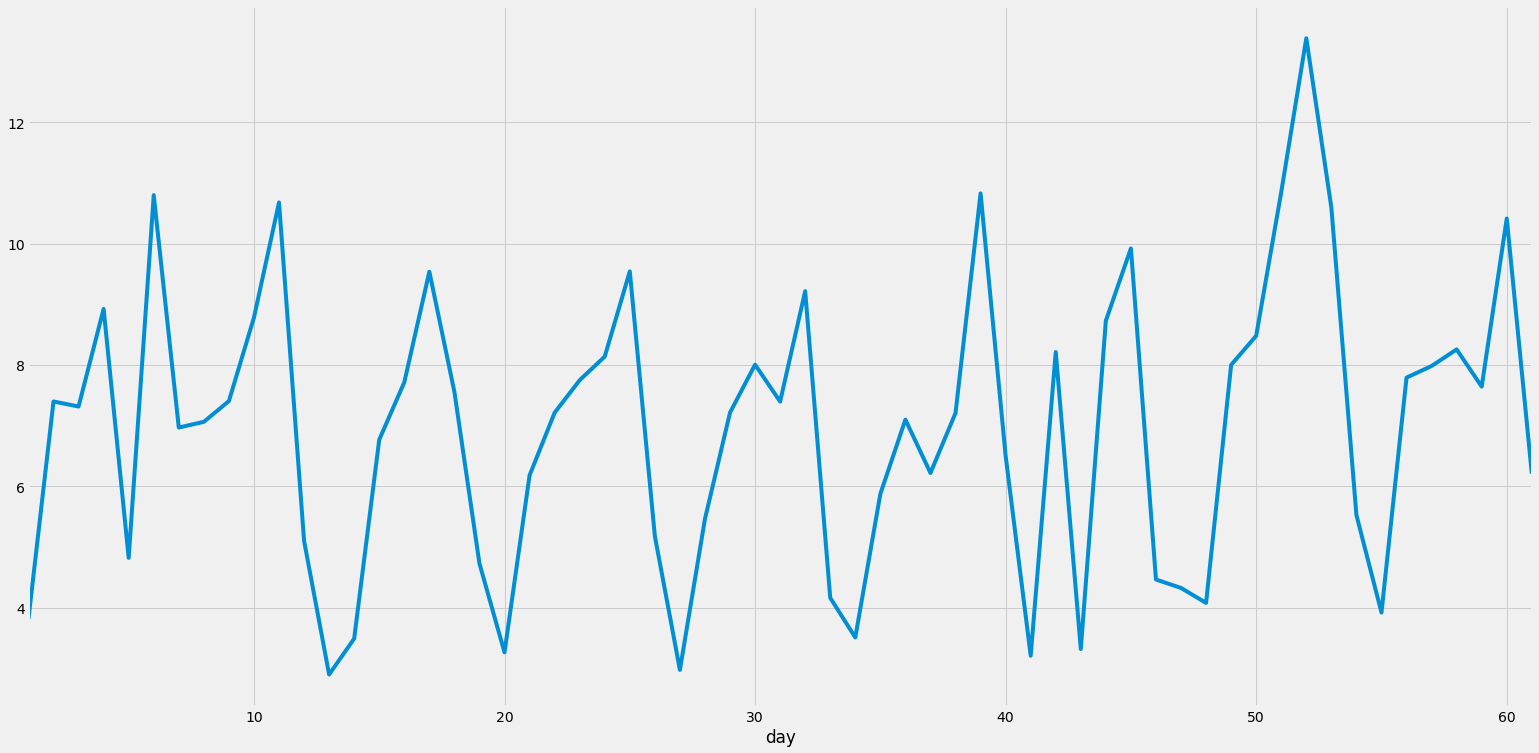

In [29]:
df_t.plot(figsize=(24,12))

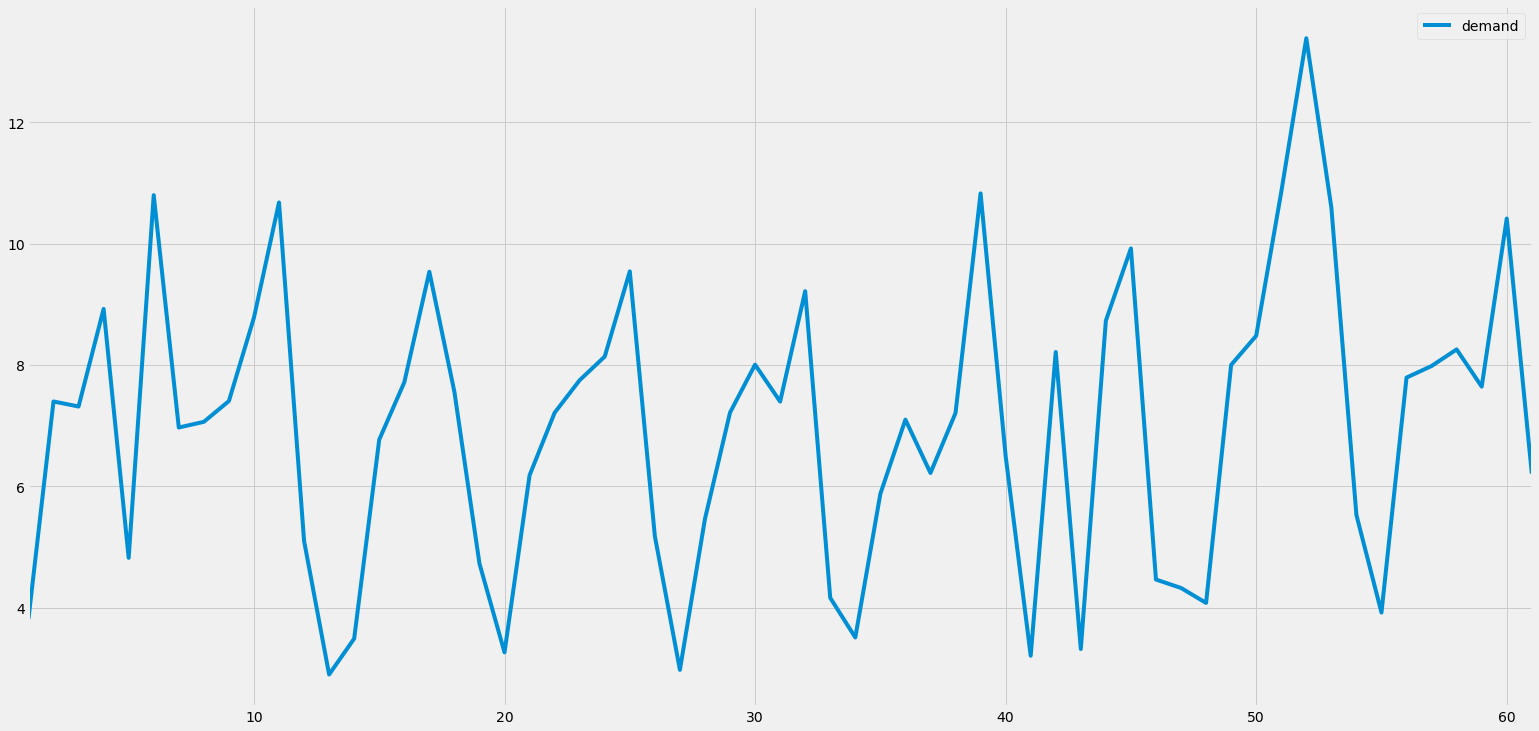

In [31]:
df_for.plot(figsize=(24,12))

In [32]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [33]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
arimaval=5000
count=0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_for,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        if results.aic<arimaval:  
            arimaval=results.aic
        else:
            arimaval=arimaval
        count+=1

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:412.84519093501365
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:323.5184765502679
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:247.83126738363833
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:191.00164031836667
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:253.8597230119638
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:231.02390841386628
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:202.16816522001852
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:190.9884202512928
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:352.2511683126862
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:284.92852667310916
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:242.60749325030878
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:189.54677387206493
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:251.4085164306777
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:229.0294823126721
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:203.74823832355736
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:188.4853944382788
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:293.3991745895036
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:251.1637758425226
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:26

In [34]:
print(arimaval)

186.1562974880195


In [35]:
mod = sm.tsa.statespace.SARIMAX(df_for,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8759      0.088     -9.954      0.000      -1.048      -0.703
ma.S.L7       -0.8464      0.252     -3.357      0.001      -1.341      -0.352
sigma2         3.2411      0.775      4.180      0.000       1.721       4.761


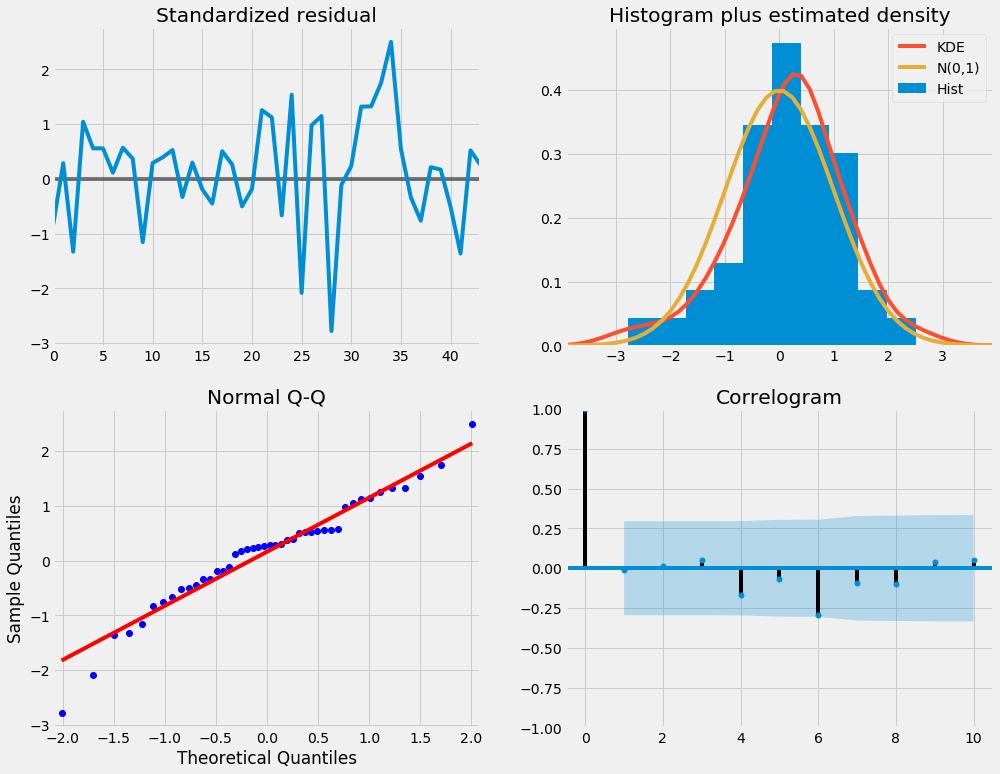

In [36]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
pred = results.get_prediction(start=50, dynamic=False)
pred_ci = pred.conf_int()
pred

In [46]:
ax = df_for[1:].plot(label='observed', figsize=(15, 8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15, 8))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()

plt.show()

,lower demand,upper demand,Forecast
62,1.330523,8.471301,4.900912


In [44]:
y_forecasted = pred.predicted_mean
y_truth = df_for['demand'][50:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.93


In [54]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=10)


# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

pred_ci1=pred_ci
pred_ci1['Forecast']=(pred_ci1['lower demand']+pred_ci1['upper demand'])/2
pred_ci1

,lower demand,upper demand,Forecast
62,1.330523,8.471301,4.900912
63,3.853494,11.048900,7.451197
64,4.043371,11.292993,7.668182
65,5.285268,12.585945,8.935607
66,6.029578,13.383366,9.706472
67,6.196190,13.602708,9.899449
68,2.260158,9.719033,5.989595
69,1.141585,8.897002,5.019294
70,3.657553,11.481603,7.569578
71,3.840520,11.732607,7.786563


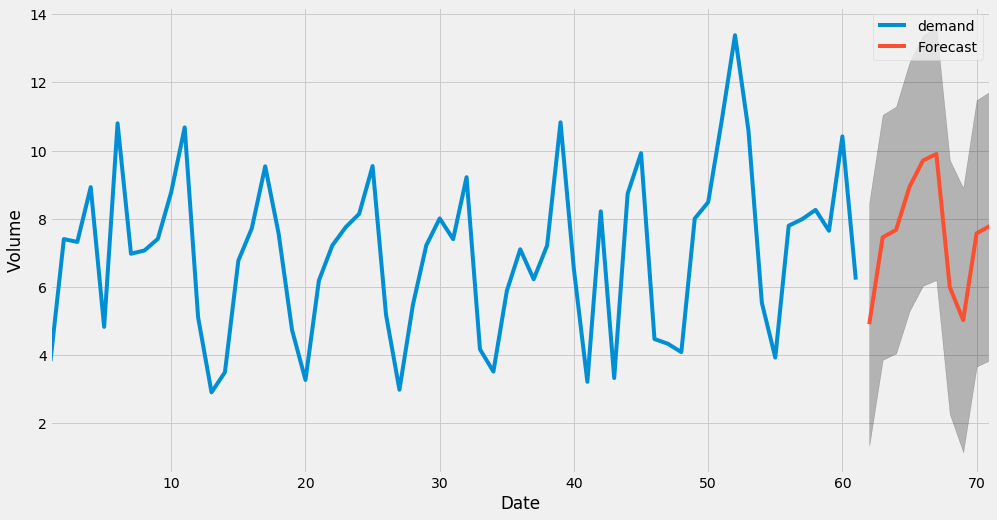

In [55]:
ax = df_for.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()